# Accelerate SetFit Models with 🤗 Optimum Intel

In this notebook, we'll show how you can use 🤗 [Optimum Intel](https://github.com/huggingface/optimum-intel) to speed up your SetFit models on Intel CPUs.\
Optimum Intel is the interface between the 🤗 Transformers and Diffusers libraries and the different tools and libraries provided by Intel to accelerate end-to-end pipelines on Intel architectures.

In our experiments, we will be using a fine-tuned SetFit model based on `bge-small-en-v1.5` sentence transformer model and observe our performance increase.

### Prerequisites

* Linux OS
* Python 3.9+
* An Intel Xeon Processor which supports [bfloat16](https://www.intel.com/content/www/us/en/developer/articles/technical/pytorch-on-xeon-processors-with-bfloat16.html)

Since Google Colab doesn't meet the hardware requirement, it's incompatible with this notebook and will not see speedups from our optimizations.

Please run the following to ensure you meet the requirements.

In [1]:
import sys
import os
from time import sleep

os_info = !uname -o
os_type = os_info[0]
is_os_ok = "linux" in os_type.lower()
is_python_ver_ok = sys.version_info.major == 3 and sys.version_info.minor >=9
cpu_info = !lscpu
is_cpu_ok = "intel" in cpu_info.grep("vendor")[0].lower() and "bf16" in cpu_info.grep("flags")[0]
if not is_os_ok:
    print(f"This notebook requires a Linux type operating system, but you have {os_type}")
if not is_python_ver_ok:
    print(f"This notebook requires Python 3.9+ but your version is {sys.version.split()[0]}.")
if not is_cpu_ok:
    print(f"Your CPU does not support bfloat16.")
print(f"Notebook requirements {'' if is_os_ok and is_python_ver_ok and is_cpu_ok else 'not'} met.")

Notebook requirements  met.


### Before Running this Notebook
1. Please create a `conda` environment and install `jupyterlab`:
```bash
conda create -n setfit python=3.10 -y && conda activate setfit
python -m pip install -U jupyterlab
```

2. Install **TCMalloc**: Google's fast, multi-threaded `malloc()` implementation:
```bash
conda install gperftools -c conda-forge -y
echo export LD_PRELOAD=${CONDA_PREFIX}/lib/libtcmalloc.so:$LD_PRELOAD >> ~/.bashrc
# **** Restart the shell or `source ~/.bashrc` ****
```

3. Launch the notebook using `numactl` (explained below), for example: 
```bash
OMP_NUM_THREADS=56 numactl -C 0-55 -m 0 jupyter lab
```

### Reproducibility
This notebook was tested on `Ubuntu 22.04.3 LTS` and `Python 3.10.13`.

To reproduce the maximum speeds reported in this notebook, please launch it using `numactl`.\
`numactl` enables gaining better control on which resources you're running. It's best to run on a single socket (`-m 0`):\
`OMP_NUM_THREADS=<NUM_THREADS> numactl -C <CORES_RANGE> -m 0 jupyter lab`

### Setup
Install the required packages to evaluate and visualize results for SetFit models:

In [2]:
!python -m pip install -U setfit evaluate matplotlib -qqq

### Install Optimum Intel

Install Optimum Intel along with INC and IPEX backends which we'll use in our optimization later on.

In [3]:
!python -m pip install --upgrade-strategy eager optimum[neural-compressor] -qqq
!python -m pip install intel-extension-for-pytorch -qqq

### Set Up Benchmark

First, define the infrastructure for conducting latency, throughput and accuracy benchmarks.

In [4]:
import sys
import os
from time import sleep
from pathlib import Path
from time import perf_counter
import warnings
import subprocess
import sys
from collections import defaultdict

import evaluate
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm.auto import trange
from sentence_transformers import SentenceTransformer
from setfit.exporters.utils import mean_pooling
import logging

logging.getLogger("sentence_transformers").setLevel(logging.ERROR)
warnings.filterwarnings("ignore")
os.environ["TOKENIZERS_PARALLELISM"] = "false"

def get_dir_size(path):
    ps = subprocess.Popen(('du','-hk', path), stdout=subprocess.PIPE)
    output = subprocess.check_output(("awk", "{print $1/1024,$2}"), stdin=ps.stdout)
    ps.wait()
    return float(output.split()[0].decode('utf-8'))

class PerformanceBenchmark:
    def __init__(self, model, dataset, optim_type, max_sequence_length=512, metric="accuracy",
                 model_path=None, autocast_dtype=None, batch_sizes=None):
        self.model = model
        self.dataset = dataset
        self.optim_type = optim_type
        self.metric = evaluate.load(metric)
        self.model_path = model_path
        self.tokenizer = self.model.model_body.tokenizer
        self.vocab_size = self.tokenizer.vocab_size
        self.max_length = max_sequence_length
        self.device = self.model.model_body.device
        self.batch_sizes = [2 ** i for i in range(10)] if batch_sizes is None else batch_sizes
        self.autocast_dtype = autocast_dtype
        self.model.model_body.eval()

        if "ipex" in optim_type:
            body = ipex.optimize(self.model.model_body, dtype=self.autocast_dtype)
            d = self.generate_random_sequences(batch_size=1)
            body = torch.jit.trace(body, (d,), check_trace=False, strict=False)
            self.model.model_body = torch.jit.freeze(body)
            
    def to_device(self, batch):
        for key in batch:
            batch[key] = batch[key].to(self.device)
        return batch

    @torch.inference_mode()
    def timed_predict(self, inputs=None, encoded_inputs=None):
        if encoded_inputs is None:
            encoded_inputs = self.tokenizer(
            inputs, padding="max_length", max_length=self.max_length, truncation=True, return_tensors="pt"
        )
        start = perf_counter()
        encoded_inputs = self.to_device(encoded_inputs)
        
        with torch.no_grad(), torch.cpu.amp.autocast(dtype=self.autocast_dtype, enabled=self.autocast_dtype is not None):                
            if isinstance(self.model.model_body, SentenceTransformer) or "ipex" in self.optim_type:
                embeddings = self.model.model_body(encoded_inputs)["sentence_embedding"]
            else:
                # Quantized SetFit model bodies don't include mean pooling
                outputs = self.model.model_body(**encoded_inputs)
                embeddings = mean_pooling(outputs["last_hidden_state"], encoded_inputs["attention_mask"])
                
            preds = self.model.model_head.predict(embeddings)
            latency = perf_counter() - start
        return preds, latency

    def compute_accuracy(self):
        preds, _ = self.timed_predict(self.dataset["text"])
        accuracy = self.metric.compute(predictions=preds, references=self.dataset["label"])
        print(f"Accuracy on test set - {accuracy['accuracy']:.3f}")
        return accuracy
        
    def compute_size(self):
        if self.model_path is None:
            tmp_path = Path("model.pt")
            try:
                with open(tmp_path, "wb") as f:
                    torch.jit.save(self.model.model_body, f)
            except:
                state_dict = self.model.model_body.state_dict()
                torch.save(state_dict, tmp_path)
            
            size_mb = get_dir_size(tmp_path)
            # Delete temporary file
            tmp_path.unlink()
        else:
            size_mb = get_dir_size(self.model_path)
        print(f"Model size (MB) - {size_mb:.2f}")
        return {"size_mb": size_mb}

    def generate_random_sequences(self, batch_size):
        input_ids = torch.randint(0, self.vocab_size - 1, (batch_size, self.max_length))
        token_type_ids = torch.zeros((batch_size, self.max_length), dtype=torch.int64)
        attention_mask = torch.ones((batch_size, self.max_length), dtype=torch.int64)
        return {
            "input_ids": input_ids,
            "token_type_ids": token_type_ids,
            "attention_mask": attention_mask,
        }

    def compute_latency_and_throughput(self, num_iter=100, num_warmup_iter=40):
        res = defaultdict(list)
        for batch_size in self.batch_sizes:
            try:
                for _ in trange(num_warmup_iter, desc=f"Warmup ({batch_size=})", file=sys.stdout):
                    encoded_inputs = self.generate_random_sequences(batch_size=batch_size)
                    _ = self.timed_predict(encoded_inputs=encoded_inputs)
    
                batch_latencies = []
                for _ in trange(num_iter, desc=f"Timed Run ({batch_size=})", file=sys.stdout):
                    encoded_inputs = self.generate_random_sequences(batch_size=batch_size)
                    _, latency = self.timed_predict(encoded_inputs=encoded_inputs)
                    batch_latencies.append(latency)
        
                # Compute run statistics
                batch_latencies = np.array(batch_latencies)
                if batch_size == 1:
                    latency = 1000 * (batch_latencies / batch_size)
                    res.update({"time_avg_ms": np.mean(latency), "time_std_ms": np.std(latency)})
                    print(f"Avg. latency (ms), {batch_size=} - {res['time_avg_ms']:.2f} +/- {res['time_std_ms']:.2f}")
    
                throughputs = batch_size / batch_latencies
                res["throughputs_avg"].append(np.mean(throughputs))
                res["throughputs_std"].append(np.std(throughputs))
                print(f"Avg. throughput (samples/sec), {batch_size=} - {res['throughputs_avg'][-1]:.1f} +/- {res['throughputs_std'][-1]:.1f}")
                res["batch_sizes"].append(batch_size)
            except Exception as e:
                print(f"Skipping throughput computation at {batch_size=} since it failed with the following error: \n\n{e}\n")
        return res
        
    def run_benchmark(self):
        print(f"\n\n{'*' * 150}\nOptimization type: {self.optim_type}\n{'*' * 150}")
        all_metrics = {}
        for run_metric in self.compute_accuracy, self.compute_latency_and_throughput, self.compute_size:
            all_metrics |= run_metric()
            print("=" * 100)
        return {self.optim_type: all_metrics}

Let's add a function to plot our results.

In [17]:
import pandas as pd

def plot_metrics(perf_metrics):
    df = pd.DataFrame.from_dict(perf_metrics, orient="index")
    plt.figure(figsize=(6, 4), dpi=120)
    for idx in df.index:
        df_opt = df.loc[idx]
        x, y = df_opt["time_avg_ms"], df_opt["accuracy"] * 100
        plt.errorbar(
            x,
            y,
            xerr=df_opt["time_std_ms"],
            fmt="o",
            alpha=0.5,
            ms=df_opt["size_mb"] / 15,
            label=idx,
            capsize=5,
            capthick=1,
        )
        plt.text(x, y-3, f'{y:.1f}\n{x:.1f}ms', va='bottom', fontsize=6, color="black")
        
    plt.suptitle("Accuracy vs Latency (batch_size=1)")
    plt.title('\nBAAI/bge-small-en-v1.5 SetFit model trained on SetFit/sst2', fontsize=8)
    legend = plt.legend(loc="lower right")
    plt.ylim(63, 95)
    # Use the slowest model to define the x-axis range
    xlim = max([metrics["time_avg_ms"] for metrics in perf_metrics.values()]) * 1.3
    plt.xlim(0, xlim)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Latency (ms)")
    plt.savefig("accuracy_vs_latency.png")
    plt.show()

## 1. Benchmark SetFit using 🤗 Transformers

Load the dataset for running evaluations:

In [6]:
from datasets import load_dataset
from setfit import SetFitModel

test_dataset = load_dataset("SetFit/sst2")["validation"]

# Prepare variables for benchmarks
model_path = "dkorat/bge-small-en-v1.5_setfit-sst2-english"
perf_metrics = {}

We'll now run the benchmark with the standard 🤗 Transformers backend:

In [7]:
setfit_model = SetFitModel.from_pretrained(model_path)
pb = PerformanceBenchmark(
    model=setfit_model, 
    dataset=test_dataset, 
    optim_type="bge-small (transformers)",
)
perf_metrics.update(pb.run_benchmark())



******************************************************************************************************************************************************
Optimization type: bge-small (transformers)
******************************************************************************************************************************************************
Accuracy on test set - 0.884


Warmup (batch_size=1):   0%|          | 0/40 [00:00<?, ?it/s]

Timed Run (batch_size=1):   0%|          | 0/100 [00:00<?, ?it/s]

Avg. latency (ms), batch_size=1 - 15.69 +/- 0.57
Avg. throughput (samples/sec), batch_size=1 - 63.8 +/- 2.4


Warmup (batch_size=2):   0%|          | 0/40 [00:00<?, ?it/s]

Timed Run (batch_size=2):   0%|          | 0/100 [00:00<?, ?it/s]

Avg. throughput (samples/sec), batch_size=2 - 84.9 +/- 1.0


Warmup (batch_size=4):   0%|          | 0/40 [00:00<?, ?it/s]

Timed Run (batch_size=4):   0%|          | 0/100 [00:00<?, ?it/s]

Avg. throughput (samples/sec), batch_size=4 - 110.6 +/- 1.3


Warmup (batch_size=8):   0%|          | 0/40 [00:00<?, ?it/s]

Timed Run (batch_size=8):   0%|          | 0/100 [00:00<?, ?it/s]

Avg. throughput (samples/sec), batch_size=8 - 119.6 +/- 7.4


Warmup (batch_size=16):   0%|          | 0/40 [00:00<?, ?it/s]

Timed Run (batch_size=16):   0%|          | 0/100 [00:00<?, ?it/s]

Avg. throughput (samples/sec), batch_size=16 - 115.3 +/- 8.2


Warmup (batch_size=32):   0%|          | 0/40 [00:00<?, ?it/s]

Timed Run (batch_size=32):   0%|          | 0/100 [00:00<?, ?it/s]

Avg. throughput (samples/sec), batch_size=32 - 83.8 +/- 3.6


Warmup (batch_size=64):   0%|          | 0/40 [00:00<?, ?it/s]

Timed Run (batch_size=64):   0%|          | 0/100 [00:00<?, ?it/s]

Avg. throughput (samples/sec), batch_size=64 - 81.5 +/- 1.2


Warmup (batch_size=128):   0%|          | 0/40 [00:00<?, ?it/s]

Timed Run (batch_size=128):   0%|          | 0/100 [00:00<?, ?it/s]

Avg. throughput (samples/sec), batch_size=128 - 61.7 +/- 11.2


Warmup (batch_size=256):   0%|          | 0/40 [00:00<?, ?it/s]

Timed Run (batch_size=256):   0%|          | 0/100 [00:00<?, ?it/s]

Avg. throughput (samples/sec), batch_size=256 - 74.8 +/- 0.5


Warmup (batch_size=512):   0%|          | 0/40 [00:00<?, ?it/s]

Timed Run (batch_size=512):   0%|          | 0/100 [00:00<?, ?it/s]

Avg. throughput (samples/sec), batch_size=512 - 66.1 +/- 3.7
Model size (MB) - 127.33


## 2. Optimize with IPEX+TorchScript - Using Float32 / BFloat16 Precision

In [8]:
import intel_extension_for_pytorch as ipex

for dtype in torch.float32, torch.bfloat16:
    setfit_model = SetFitModel.from_pretrained(model_path)
    
    pb = PerformanceBenchmark(
        model=setfit_model,
        dataset=test_dataset,
        optim_type=f"bge-small (ipex-{str(dtype).split('.')[1]})",
        autocast_dtype=dtype,
    )
    perf_metrics.update(pb.run_benchmark())



******************************************************************************************************************************************************
Optimization type: bge-small (ipex-float32)
******************************************************************************************************************************************************
Accuracy on test set - 0.884


Warmup (batch_size=1):   0%|          | 0/40 [00:00<?, ?it/s]

Timed Run (batch_size=1):   0%|          | 0/100 [00:00<?, ?it/s]

Avg. latency (ms), batch_size=1 - 13.07 +/- 0.39
Avg. throughput (samples/sec), batch_size=1 - 76.6 +/- 2.2


Warmup (batch_size=2):   0%|          | 0/40 [00:00<?, ?it/s]

Timed Run (batch_size=2):   0%|          | 0/100 [00:00<?, ?it/s]

Avg. throughput (samples/sec), batch_size=2 - 95.8 +/- 2.2


Warmup (batch_size=4):   0%|          | 0/40 [00:00<?, ?it/s]

Timed Run (batch_size=4):   0%|          | 0/100 [00:00<?, ?it/s]

Avg. throughput (samples/sec), batch_size=4 - 119.5 +/- 12.8


Warmup (batch_size=8):   0%|          | 0/40 [00:00<?, ?it/s]

Timed Run (batch_size=8):   0%|          | 0/100 [00:00<?, ?it/s]

Avg. throughput (samples/sec), batch_size=8 - 137.3 +/- 9.8


Warmup (batch_size=16):   0%|          | 0/40 [00:00<?, ?it/s]

Timed Run (batch_size=16):   0%|          | 0/100 [00:00<?, ?it/s]

Avg. throughput (samples/sec), batch_size=16 - 144.2 +/- 7.4


Warmup (batch_size=32):   0%|          | 0/40 [00:00<?, ?it/s]

Timed Run (batch_size=32):   0%|          | 0/100 [00:00<?, ?it/s]

Avg. throughput (samples/sec), batch_size=32 - 104.9 +/- 22.2


Warmup (batch_size=64):   0%|          | 0/40 [00:00<?, ?it/s]

Timed Run (batch_size=64):   0%|          | 0/100 [00:00<?, ?it/s]

Avg. throughput (samples/sec), batch_size=64 - 98.6 +/- 10.4


Warmup (batch_size=128):   0%|          | 0/40 [00:00<?, ?it/s]

Timed Run (batch_size=128):   0%|          | 0/100 [00:00<?, ?it/s]

Avg. throughput (samples/sec), batch_size=128 - 82.9 +/- 2.6


Warmup (batch_size=256):   0%|          | 0/40 [00:00<?, ?it/s]

Timed Run (batch_size=256):   0%|          | 0/100 [00:00<?, ?it/s]

Avg. throughput (samples/sec), batch_size=256 - 104.3 +/- 1.0


Warmup (batch_size=512):   0%|          | 0/40 [00:00<?, ?it/s]

Timed Run (batch_size=512):   0%|          | 0/100 [00:00<?, ?it/s]

Avg. throughput (samples/sec), batch_size=512 - 62.0 +/- 0.3
Model size (MB) - 127.33


******************************************************************************************************************************************************
Optimization type: bge-small (ipex-bfloat16)
******************************************************************************************************************************************************
Accuracy on test set - 0.884


Warmup (batch_size=1):   0%|          | 0/40 [00:00<?, ?it/s]

Timed Run (batch_size=1):   0%|          | 0/100 [00:00<?, ?it/s]

Avg. latency (ms), batch_size=1 - 5.67 +/- 0.66
Avg. throughput (samples/sec), batch_size=1 - 178.3 +/- 16.5


Warmup (batch_size=2):   0%|          | 0/40 [00:00<?, ?it/s]

Timed Run (batch_size=2):   0%|          | 0/100 [00:00<?, ?it/s]

Avg. throughput (samples/sec), batch_size=2 - 247.4 +/- 7.7


Warmup (batch_size=4):   0%|          | 0/40 [00:00<?, ?it/s]

Timed Run (batch_size=4):   0%|          | 0/100 [00:00<?, ?it/s]

Avg. throughput (samples/sec), batch_size=4 - 338.7 +/- 6.6


Warmup (batch_size=8):   0%|          | 0/40 [00:00<?, ?it/s]

Timed Run (batch_size=8):   0%|          | 0/100 [00:00<?, ?it/s]

Avg. throughput (samples/sec), batch_size=8 - 424.2 +/- 6.2


Warmup (batch_size=16):   0%|          | 0/40 [00:00<?, ?it/s]

Timed Run (batch_size=16):   0%|          | 0/100 [00:00<?, ?it/s]

Avg. throughput (samples/sec), batch_size=16 - 481.5 +/- 6.0


Warmup (batch_size=32):   0%|          | 0/40 [00:00<?, ?it/s]

Timed Run (batch_size=32):   0%|          | 0/100 [00:00<?, ?it/s]

Avg. throughput (samples/sec), batch_size=32 - 537.4 +/- 2.6


Warmup (batch_size=64):   0%|          | 0/40 [00:00<?, ?it/s]

Timed Run (batch_size=64):   0%|          | 0/100 [00:00<?, ?it/s]

Avg. throughput (samples/sec), batch_size=64 - 573.7 +/- 3.9


Warmup (batch_size=128):   0%|          | 0/40 [00:00<?, ?it/s]

Timed Run (batch_size=128):   0%|          | 0/100 [00:00<?, ?it/s]

Avg. throughput (samples/sec), batch_size=128 - 582.7 +/- 8.9


Warmup (batch_size=256):   0%|          | 0/40 [00:00<?, ?it/s]

Timed Run (batch_size=256):   0%|          | 0/100 [00:00<?, ?it/s]

Avg. throughput (samples/sec), batch_size=256 - 556.3 +/- 1.1


Warmup (batch_size=512):   0%|          | 0/40 [00:00<?, ?it/s]

Timed Run (batch_size=512):   0%|          | 0/100 [00:00<?, ?it/s]

Avg. throughput (samples/sec), batch_size=512 - 536.9 +/- 1.0
Model size (MB) - 63.74


## 3. Optimize with 🤗 Optimum Intel

In order to optimize our SetFit model, we will apply quantization to the model body, using Intel [Neural Compressor](https://www.intel.com/content/www/us/en/developer/tools/oneapi/neural-compressor.html) (INC), part of Optimum Intel.

**Quantization** is a very popular deep learning model optimization technique for improving inference speeds. It minimizes the number of bits required to represent the weights and/or activations in a neural network. This is done by converting a set of real-valued numbers into their lower-bit data representations, such as INT8. Moreover, quantization can enable faster computations in lower precision.

Specifically, we'll apply post-training static quantization (PTQ). PTQ can reduce the memory footprint and latency for inference, while still preserving the accuracy of the model, with only a small unlabeled calibration set and without any training.

#### Prepare a Calibration Dataset

The calibration dataset should be able to represent the data distribution of unseen data. In general, preparing 100 samples is enough for calibration. We'll use the `rotten_tomatoes` dataset in our case, since it’s composed of movie reviews, like our target dataset, sst2. First, we’ll load 100 random samples from this dataset.

In [9]:
calibration_set = load_dataset("rotten_tomatoes")["train"].shuffle(seed=42).select(range(100))  
calibration_set["text"][:2]

['. . . plays like somebody spliced random moments of a chris rock routine into what is otherwise a cliche-riddled but self-serious spy thriller .',
 "michael moore has perfected the art of highly entertaining , self-aggrandizing , politically motivated documentary-making , and he's got as potent a topic as ever here ."]

To prepare the dataset for quantization, we'll need to tokenize each example. We won’t need the “text” and “label” columns, so let’s remove them.

In [10]:
def tokenize(examples):
    return tokenizer(examples["text"], padding="max_length", max_length=tokenizer.model_max_length, truncation=True)

setfit_model = SetFitModel.from_pretrained(model_path)
tokenizer = setfit_model.model_body.tokenizer
calibration_set = calibration_set.map(tokenize, num_proc=10).remove_columns(["text", "label"])

#### Run Quantization
Now we define the desired quantization process - in our case - Static Post Training Quantization, and use `optimum.intel` to run the quantization on our calibration dataset:

In [11]:
from optimum.intel import INCQuantizer
from neural_compressor.config import PostTrainingQuantConfig

setfit_body = setfit_model.model_body[0].auto_model
quantizer = INCQuantizer.from_pretrained(setfit_body)
optimum_model_path = "/tmp/bge-small-en-v1.5_setfit-sst2-english_opt"
quantization_config = PostTrainingQuantConfig(approach="static", backend="ipex", domain="nlp")
quantizer.quantize(
    quantization_config=quantization_config,
    calibration_dataset=calibration_set,
    save_directory=optimum_model_path,
    batch_size=1,
)
tokenizer.save_pretrained(optimum_model_path);

ONNX export is no supported for model with quantized embeddings
2024-03-28 04:07:29 [INFO] Start auto tuning.
2024-03-28 04:07:29 [INFO] Execute the tuning process due to detect the evaluation function.
2024-03-28 04:07:29 [INFO] Adaptor has 5 recipes.
2024-03-28 04:07:29 [INFO] 0 recipes specified by user.
2024-03-28 04:07:29 [INFO] 3 recipes require future tuning.
2024-03-28 04:07:29 [WARNING] Fail to remove /home/sdp/dkorat/setfit/notebooks/nc_workspace/2024-03-28_04-07-26/ipex_config_tmp.json.
2024-03-28 04:07:29 [INFO] *** Initialize auto tuning
2024-03-28 04:07:29 [INFO] {
2024-03-28 04:07:29 [INFO]     'PostTrainingQuantConfig': {
2024-03-28 04:07:29 [INFO]         'AccuracyCriterion': {
2024-03-28 04:07:29 [INFO]             'criterion': 'relative',
2024-03-28 04:07:29 [INFO]             'higher_is_better': True,
2024-03-28 04:07:29 [INFO]             'tolerable_loss': 0.01,
2024-03-28 04:07:29 [INFO]             'absolute': None,
2024-03-28 04:07:29 [INFO]             'keys': 

#### Benchmark Optimum Model

This next class defines a wrapper around our SetFit model which plugs in our quantized model at inference (instead of the original model body).

In [12]:
class OptimumSetFitModel:
    def __init__(self, setfit_model, model_body):
        model_body.tokenizer = setfit_model.model_body.tokenizer
        self.model_body = model_body
        self.model_head = setfit_model.model_head

Time to run the performance benchmark on our optimized SetFit model!

In [13]:
from optimum.intel import IPEXModel

optimum_model = IPEXModel.from_pretrained(optimum_model_path)
optimum_setfit_model = OptimumSetFitModel(setfit_model, model_body=optimum_model)

pb = PerformanceBenchmark(
    model=optimum_setfit_model,
    dataset=test_dataset,
    optim_type=f"bge-small (optimum-int8)",
    model_path=optimum_model_path,
    autocast_dtype=torch.bfloat16,
)
perf_metrics.update(pb.run_benchmark())

Passing the argument `library_name` to `get_supported_tasks_for_model_type` is required, but got library_name=None. Defaulting to `transformers`. An error will be raised in a future version of Optimum if `library_name` is not provided.




******************************************************************************************************************************************************
Optimization type: bge-small (optimum-int8)
******************************************************************************************************************************************************
Accuracy on test set - 0.881


Warmup (batch_size=1):   0%|          | 0/40 [00:00<?, ?it/s]

Timed Run (batch_size=1):   0%|          | 0/100 [00:00<?, ?it/s]

Avg. latency (ms), batch_size=1 - 4.55 +/- 0.25
Avg. throughput (samples/sec), batch_size=1 - 220.2 +/- 9.4


Warmup (batch_size=2):   0%|          | 0/40 [00:00<?, ?it/s]

Timed Run (batch_size=2):   0%|          | 0/100 [00:00<?, ?it/s]

Avg. throughput (samples/sec), batch_size=2 - 254.3 +/- 9.4


Warmup (batch_size=4):   0%|          | 0/40 [00:00<?, ?it/s]

Timed Run (batch_size=4):   0%|          | 0/100 [00:00<?, ?it/s]

Avg. throughput (samples/sec), batch_size=4 - 384.8 +/- 9.0


Warmup (batch_size=8):   0%|          | 0/40 [00:00<?, ?it/s]

Timed Run (batch_size=8):   0%|          | 0/100 [00:00<?, ?it/s]

Avg. throughput (samples/sec), batch_size=8 - 536.3 +/- 9.5


Warmup (batch_size=16):   0%|          | 0/40 [00:00<?, ?it/s]

Timed Run (batch_size=16):   0%|          | 0/100 [00:00<?, ?it/s]

Avg. throughput (samples/sec), batch_size=16 - 646.3 +/- 13.8


Warmup (batch_size=32):   0%|          | 0/40 [00:00<?, ?it/s]

Timed Run (batch_size=32):   0%|          | 0/100 [00:00<?, ?it/s]

Avg. throughput (samples/sec), batch_size=32 - 790.2 +/- 7.9


Warmup (batch_size=64):   0%|          | 0/40 [00:00<?, ?it/s]

Timed Run (batch_size=64):   0%|          | 0/100 [00:00<?, ?it/s]

Avg. throughput (samples/sec), batch_size=64 - 896.2 +/- 9.1


Warmup (batch_size=128):   0%|          | 0/40 [00:00<?, ?it/s]

Timed Run (batch_size=128):   0%|          | 0/100 [00:00<?, ?it/s]

Avg. throughput (samples/sec), batch_size=128 - 935.2 +/- 3.5


Warmup (batch_size=256):   0%|          | 0/40 [00:00<?, ?it/s]

Timed Run (batch_size=256):   0%|          | 0/100 [00:00<?, ?it/s]

Avg. throughput (samples/sec), batch_size=256 - 923.4 +/- 10.8


Warmup (batch_size=512):   0%|          | 0/40 [00:00<?, ?it/s]

Timed Run (batch_size=512):   0%|          | 0/100 [00:00<?, ?it/s]

Avg. throughput (samples/sec), batch_size=512 - 857.1 +/- 2.2
Model size (MB) - 44.65


#### Plot Latencies and Compute Latency Speedup

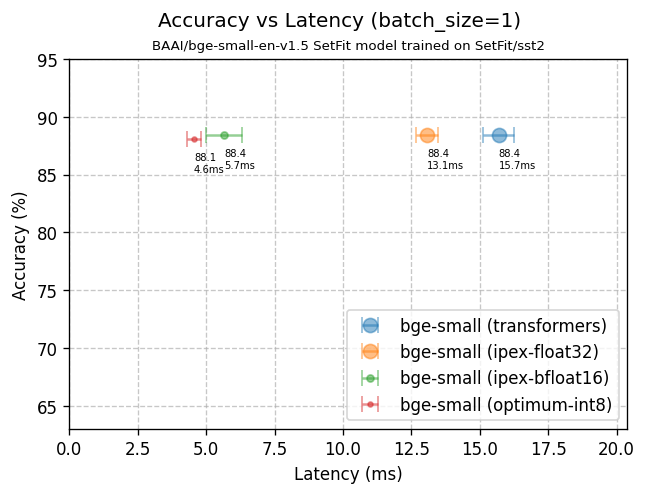

Latency speedup for 'bge-small (optimum-int8) vs bge-small (transformers)': 3.4x


In [18]:
plot_metrics(perf_metrics)
speedup = perf_metrics['bge-small (transformers)']['time_avg_ms'] / perf_metrics['bge-small (optimum-int8)']['time_avg_ms']
print(f"Latency speedup for 'bge-small (optimum-int8) vs bge-small (transformers)': {speedup:.1f}x")

#### After optimizing, inference with batch size 1 is 3.4x faster than before, with minimal drop in accuracy!

#### Throughput Speedup

Let's look now at the throughput, which is the number of samples the model can predict per second.\
We'll plot this value for our optimized and baseline models, as a function of the batch size.

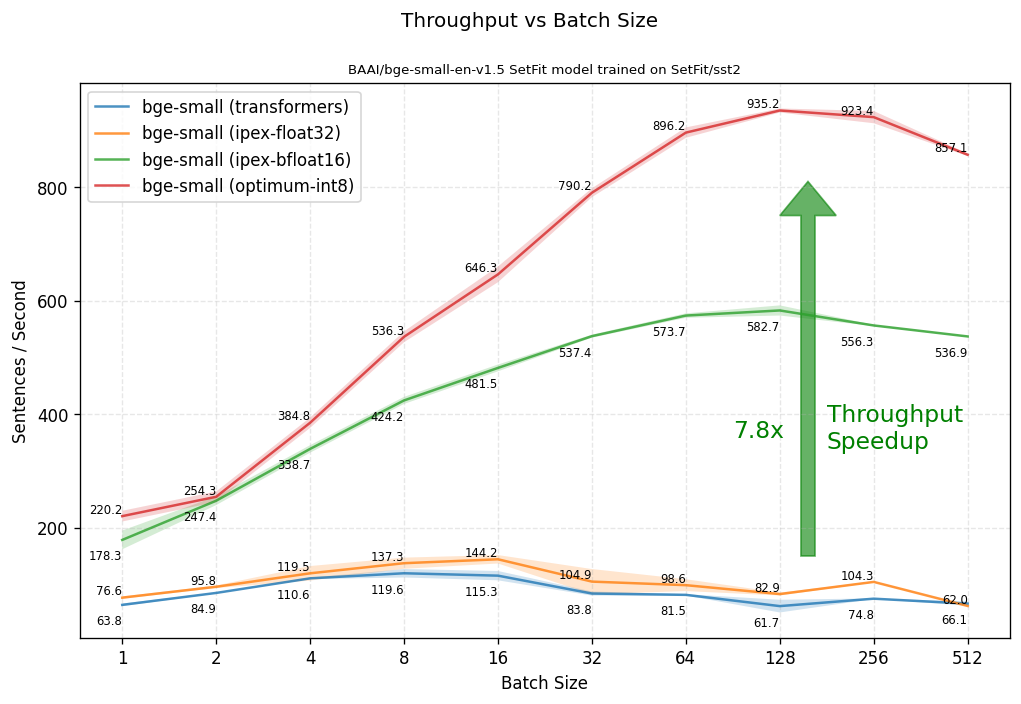

In [15]:
def plot_throughputs(perf_metrics):
    plt.figure(figsize=(10, 6), dpi=120)
    maximums = []
    for i, (label, metric) in enumerate(perf_metrics.items()):
        xs = np.arange(len(metric["batch_sizes"]))
        y_mean, y_std = np.array(metric["throughputs_avg"]), np.array(metric["throughputs_std"])
        maximums.append((np.argmax(y_mean), max(y_mean)))
        plt.plot(xs, y_mean, label=label, alpha=0.8)
        plt.fill_between(xs, y_mean - y_std, y_mean + y_std, alpha=0.2)
        for x, y in zip(xs, y_mean):
            plt.text(x, y - 40 + 40 * (i % 2), f'{y:.1f}', ha='right', va='bottom', fontsize=7, color="black")

    plt.suptitle("Throughput vs Batch Size")
    plt.title('\nBAAI/bge-small-en-v1.5 SetFit model trained on SetFit/sst2', fontsize=8)
    plt.ylabel("Sentences / Second")
    plt.xlabel("Batch Size")
    plt.xticks(xs, pb.batch_sizes[:len(xs)])
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.3)
    
    # Add Speedup Arrow
    max_opt_thoughput = max(perf_metrics['bge-small (optimum-int8)']['throughputs_avg'])
    max_transformers_thoughput = max(perf_metrics['bge-small (transformers)']['throughputs_avg'])
    speedup =  max_opt_thoughput / max_transformers_thoughput
    arrow_kwargs = dict(head_width = 0.6, width=0.15, head_length=60, color="green", alpha=0.6)
    plt.arrow(7.3, 150, 0, 600, **arrow_kwargs)
    plt.text(7.5, 340, 'Throughput\nSpeedup', color="green", fontsize=14)
    plt.text(6.5, 360, f"{speedup:.1f}x", color="green", fontsize=14)
    
    plt.savefig("throughput_vs_batch_size.png")
    plt.show()
    
plot_throughputs(perf_metrics)

#### The throughput is where our optmiziation shines - the optimized model achieves 7.8x speedup in max throughput!